# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Table of Contents





[Part 0. Get to Know the Data](#"Get-to-Know-the-Data")<br>
[Part 1: Customer Segmentation Report](#"Customer-Segmentation-Report")<br>
[Part 2: Supervised Learning Model](#"Supervised-Learning-Model")<br>
[Part 3: Kaggle Competition](#"Kaggle-Competition")<br>



## <a id="Get-to-Know-the-Data">Part 0. Get to Know the Data<br></a>

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import dsp

# magic word for producing visualizations in notebook
%matplotlib inline

/Users/jamancilla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Load feature info
feat_info = pd.read_csv('../features.csv')
feat_info.set_index('attribute', inplace=True)

# Parse missing_or_known string into a list
def parse_missing(s):
    a = s[1:-1].split(',')
    return a

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing)

In [3]:
# load in the data
azdias = pd.read_csv('../data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/jamancilla/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias.shape

(891221, 366)

In [5]:
customers.shape

(191652, 369)

In [6]:
feat_info.head()

,information_level,type,missing_or_unknown,Comment
attribute,,,,
AGER_TYP,person,categorical,"[-1, 0]",NaN
ALTER_HH,household,interval,[0],NaN
ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]",NaN
ANREDE_KZ,person,categorical,"[-1, 0]",NaN
ANZ_HAUSHALTE_AKTIV,building,numeric,[0],NaN


### Check and handle missing values

In [7]:
# Check uncoded missing values
p_missing = azdias.isnull().mean()

In [8]:
p_missing.sort_values(ascending=False).head()

ALTER_KIND4    0.998648
ALTER_KIND3    0.993077
ALTER_KIND2    0.966900
ALTER_KIND1    0.909048
EXTSEL992      0.733996
dtype: float64

In [9]:
# Find the columns not covered by feature info
missing_from_feat_info = set(azdias.columns.values).difference(feat_info.index.values)
list(missing_from_feat_info)[:12]

['D19_TELKO_ONLINE_QUOTE_12',
 'CJT_KATALOGNUTZER',
 'RT_SCHNAEPPCHEN',
 'D19_SOZIALES',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'ALTER_KIND2',
 'AKT_DAT_KL',
 'STRUKTURTYP',
 'RT_UEBERGROESSE',
 'VK_DHT4A',
 'CJT_TYP_5']

In [10]:
azdias.drop(list(missing_from_feat_info), axis='columns', inplace=True)

In [11]:
# Find columns not in the dataset
missing_azdias = set(feat_info.index.values).difference(azdias.columns.values)
missing_azdias

{'BIP_FLAG',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

In [12]:
# Convert missing values to Nans
missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.index).to_dict()
azdias[azdias.isin(missing_values)] = np.nan

#### Missing values by column

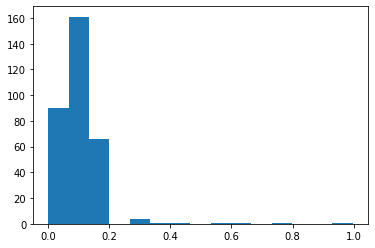

In [13]:
p_missing = azdias.isnull().mean()

plt.hist(p_missing, bins=15);

In [14]:
p_threshold = 0.2
to_drop = p_missing[p_missing > p_threshold]
to_drop.index

Index(['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_VERSAND_ONLINE_QUOTE_12', 'GEBURTSJAHR', 'KBA05_BAUMAX',
       'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [15]:
p_missing.D19_KONSUMTYP

0.2884952217239046

In [16]:
# Drop columns below acceptable threshold of missing values
azdias = azdias.drop(to_drop.index, axis='columns')

In [17]:
azdias.columns

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM',
       'CAMEO_DEU_2015', 'CAMEO_DEUG_2015',
       ...
       'SHOPPER_TYP', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'VERS_TYP',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=317)

#### Missing Values by Row

In [18]:
missing_by_row = azdias.isnull().sum(axis=1)

(array([7.37287e+05, 1.00000e+00, 3.84820e+04, 9.65100e+03, 0.00000e+00,
        5.82100e+03, 2.00000e+00, 5.43000e+02, 6.28300e+03, 9.31510e+04]),
 array([  0. ,  22.7,  45.4,  68.1,  90.8, 113.5, 136.2, 158.9, 181.6,
        204.3, 227. ]),
 <a list of 10 Patch objects>)

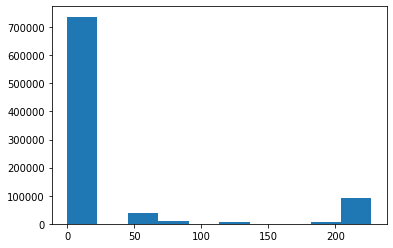

In [19]:
plt.hist(missing_by_row)

(array([612216.,  10387.,  32065.,  16359.,  13132.,   2775.,  21858.,
          9789.,  11137.,   5853.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

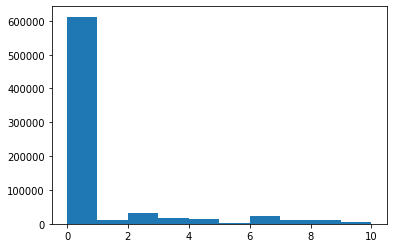

In [20]:
plt.hist(missing_by_row, range=(0,10))

In [21]:
missing_by_row.value_counts().sort_index().head(11)

0     612216
1      10387
2      32065
3      16359
4      13132
5       2775
6      21858
7       9789
8      11137
9        761
10      5092
dtype: int64

In [22]:
# Only take rows at or below threshold
threshold = 10

azdias_below = azdias[missing_by_row <= threshold]
print(azdias_below.shape[0])

azdias_above = azdias[missing_by_row > threshold]
print(azdias_above.shape[0])

735571
155650


In [23]:
print(azdias_above.shape[0]/azdias.shape[0])

0.17464803903857742


In [24]:
def do_comparison_plots(subset1, subset2, subtitle1, subtitle2, column_name):
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(10, 4))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    sns.countplot(subset1[column_name], ax=ax1)
    sns.countplot(subset2[column_name], ax=ax2)
    
    ax1.set_title(subtitle1)
    ax2.set_title(subtitle2)
    
    plt.subplots_adjust(wspace=.25)
    plt.show()

Threshold =  10


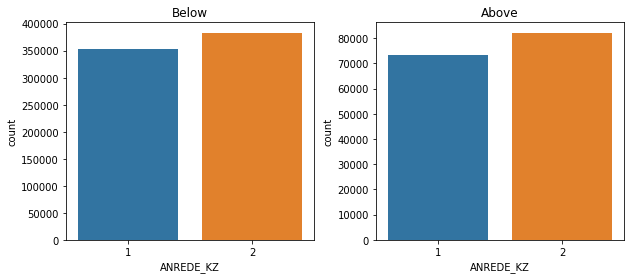

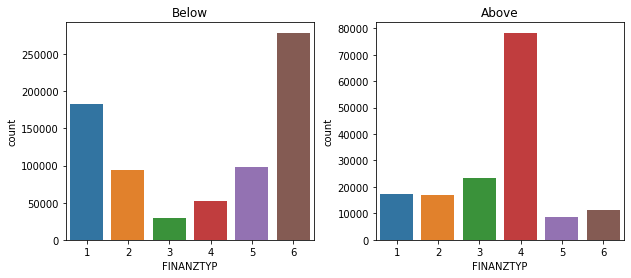

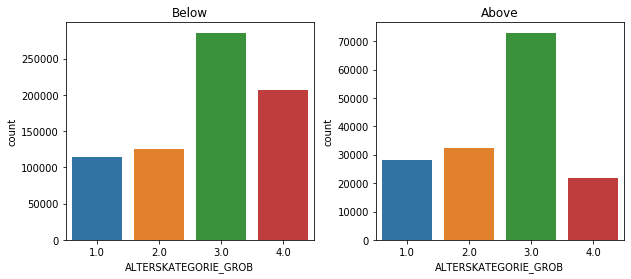

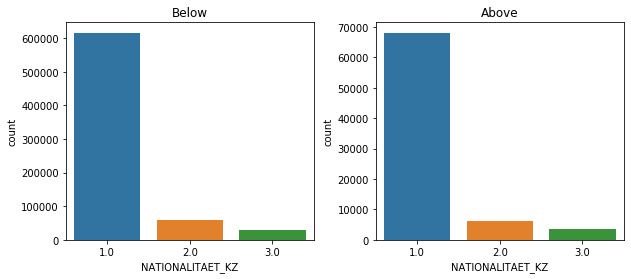

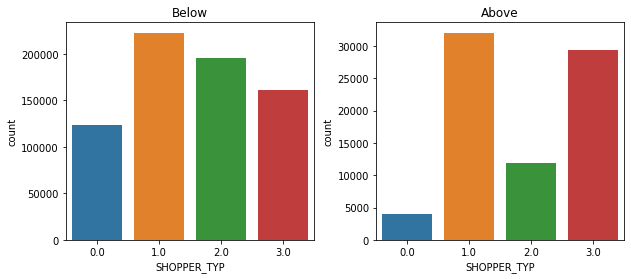

In [25]:
print("Threshold = ", threshold)
for col in ['ANREDE_KZ', 'FINANZTYP', 'ALTERSKATEGORIE_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP']:
    do_comparison_plots(azdias_below, azdias_above, 'Below', 'Above', col)

At a threshold of 0 (no missing values), 31% of the data is dropped and there are differences in FINANZTYP (finance type), ALTERSKATEGORIE_GROB (age category), and SHOPPER_TYPE. At a threshold of 10, 17.5% is dropped. And at 25, 17% is dropped.
<p>
Increasing the threshold does not remove the differences in the above features.

In [26]:
azdias = azdias_below

#### Re-Encode Categorical Features

In [27]:
feat_info.type.value_counts()

ordinal        270
categorical     42
numeric          9
binary           6
mixed            4
interval         1
Name: type, dtype: int64

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = feat_info[feat_info['type'] == 'categorical']
print('Number of orig. categorical variables: ', len(categorical))

Number of orig. categorical variables:  42


In [29]:
categorical = categorical[categorical.index.isin(azdias.columns)]
print('Number of categorical variables currently: {}\n'.format(len(categorical)))

for col in categorical.index:
    print(col, azdias[col].unique())

Number of categorical variables currently: 35

ANREDE_KZ [2 1]
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CAMEO_DEUG_2015 [8.0 4.0 2.0 6.0 1.0 9.0 7.0 5.0 3.0 nan '3' '7' '2' '4' '9' '6' '8' '5'
 '1']
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
D19_BANKEN_DATUM [10  5  8  9  7  4  6  1  2  3]
D19_BANKEN_OFFLINE_DATUM [10  9  8  2  5  4  1  6  7  3]
D19_BANKEN_ONLINE_DATUM [10  5  8  9  4  7  6  1  2  3]
D19_GESAMT_DATUM [10  1  3  5  9  7  6  8  2  4]
D19_GESAMT_OFFLINE_DATUM [10  6  8  9  5  2  4  1  7  3]
D19_GESAMT_ONLINE_DATUM [10  1  3  5  9  7  6  8  2  4]
D19_TELKO_DATUM [10  6  9  8  5  7  4  2  1  3]
D19_TELKO_OFFLINE_DATUM [10  8  5  6  9  7  4  3  2  1]
D19_TELKO_ONLINE_DATUM [10  9  7  8  6  5  4  1  2  3]
D19_VERSAND_DATUM [10  1  5  9  8  6  3  2  4  7]
D19_VERSAND_OFFLINE_D

In [30]:
# recode 10's to 0 for D19 columns
recode = categorical[categorical.index.str.startswith('D19_')].index.values
recode

array(['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM'], dtype=object)

In [31]:
azdias[recode] = azdias[recode].replace(10, 0)

In [32]:
azdias.D19_BANKEN_OFFLINE_DATUM.value_counts()

0    717698
8      5904
9      4671
5      3913
2      1864
6       470
1       407
7       304
4       280
3        60
Name: D19_BANKEN_OFFLINE_DATUM, dtype: int64

In [33]:
categorical.drop(recode, axis='rows', inplace=True)

In [34]:
# Drop all fine scale variables in favor of the rough scale version
drop = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
azdias.drop(drop, axis=1, inplace=True)

In [35]:
categorical.drop(drop, axis='rows', inplace=True)

In [36]:
# convert CAMEO_DEUG_2015 from string to float
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_DEUG_2015'].unique()

array([ 8.,  4.,  2.,  6.,  1.,  9.,  7.,  5.,  3., nan])

In [37]:
for col in categorical.index:
    print(col, azdias[col].unique())

ANREDE_KZ [2 1]
CAMEO_DEUG_2015 [ 8.  4.  2.  6.  1.  9.  7.  5.  3. nan]
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP [1 6 5 2 4 3]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_GROB [ 3.  1. nan  5.  2.  4.]
LP_STATUS_GROB [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ [ 1.  3.  2. nan]
OST_WEST_KZ ['W' 'O']
PLZ8_BAUMAX [ 1.  2.  4.  5.  3. nan]
SHOPPER_TYP [ 3.  2.  1.  0. nan]
SOHO_KZ [1. 0.]
VERS_TYP [ 2.  1. nan]
WOHNLAGE [ 4.  2.  7.  3.  5.  1.  8. nan]
ZABEOTYP [5 3 4 1 6 2]


ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, and VERS_TYP are binary and numeric.

OST_WEST_KZ is binary but will need dummy variables.

In [38]:
binary = set(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP'])
categorical.drop(binary, axis='rows', inplace=True)

In [39]:
# Re-encode categorical variable(s) to be kept in the analysis
to_recode = 'OST_WEST_KZ'
recoded = pd.get_dummies(azdias[to_recode])
recoded.head()

,O,W
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1


In [40]:
# drop the original categorical variables
azdias.drop(to_recode, axis=1, inplace=True)

# add the re-encoded one
azdias = pd.concat([azdias, recoded], axis=1)

print(azdias.columns.size)

315


#### Engineer Mixed-Type Features

In [41]:
feat_info[feat_info['type'] == 'mixed']

,information_level,type,missing_or_unknown,Comment
attribute,,,,
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]",NaN
LP_LEBENSPHASE_FEIN,person,mixed,[0],NaN
LP_LEBENSPHASE_GROB,person,mixed,[0],NaN
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]",NaN


In [42]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

print(azdias['PRAEGENDE_JUGENDJAHRE'].head())

# Create decade variable
to_replace = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
azdias['decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(to_replace)
print(azdias['decade'].head())

# Create movement variable
to_replace = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
azdias['movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(to_replace)
print(azdias['movement'].head())

azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
1    90.0
2    90.0
3    70.0
4    70.0
5    50.0
Name: decade, dtype: float64
1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: movement, dtype: float64


In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [44]:
# Create wealth variable
azdias['wealth'] = azdias.CAMEO_INTL_2015[azdias.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[0])
print(azdias['wealth'].head())

#life stage
azdias['life_stage'] = azdias.CAMEO_INTL_2015[azdias.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[1])
print(azdias['life_stage'].head())

azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

1    5
2    2
3    1
4    4
5    5
Name: wealth, dtype: object
1    1
2    4
3    2
4    3
5    4
Name: life_stage, dtype: object


In [45]:
azdias.drop(['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)

There are 4 mixed-value features.

Two were kept, PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.
- PRAEGENDE_JUGENDJAHRE was split into decade and movement. The resulting variables help fill in information that we didn't have. GEBURTSJAHR was dropped because 44% of the data was missing.
- CAMEO_INTL_2015 was split into wealth and life stage. Note: wealth categories ranges from 1 to 5 with 1 denoting wealthy and 5 denoting poorer.

Two features were dropped since the information already exists in other features:
- LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_FEIN represent combined data that is already in the dataset (LP_FAMILIE_X and LP_STATUS_X)

#### Clean data function

In [46]:
# Use data cleaning function that does all of the above
azdias = pd.read_csv('../data/Udacity_AZDIAS_052018.csv', sep=';')
print(azdias.shape)

azdias_clean, azdias_dropped = clean_data(azdias, feat_info, row_threshold=10)

/Users/jamancilla/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(891221, 366)


In [47]:
azdias_clean.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,O,W,decade,movement,wealth,life_stage
1,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8.0,5.0,...,4.0,5,2,1.0,0,1,90.0,0.0,5,1
2,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4.0,3.0,...,2.0,5,2,3.0,0,1,90.0,1.0,2,4
3,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2.0,2.0,...,7.0,3,2,4.0,0,1,70.0,0.0,1,2
4,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6.0,5.0,...,3.0,4,1,3.0,0,1,70.0,0.0,4,3
5,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,8.0,2.0,...,7.0,4,2,1.0,0,1,50.0,0.0,5,4


In [48]:
print(azdias_clean.shape)

(789433, 135)


In [49]:
### save
azdias_clean.to_csv('../data/Udacity_AZDIAS_052018_clean.csv', sep=';')

In [50]:
# Test on customer data
customers = pd.read_csv('../data/Udacity_CUSTOMERS_052018.csv', sep=';')
print(customers.shape)
customers_clean, customers_dropped = clean_data(customers, feat_info, row_threshold=10)
print(customers_clean.shape)
print(customers_dropped.shape)

/Users/jamancilla/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(191652, 369)
(140274, 135)
(51378, 137)


In [51]:
# save
customers_clean.to_csv('../data/Udacity_CUSTOMERS_052018_clean.csv', sep=';')

In [52]:
# Handle remaining missing values
azdias_clean.isnull().mean().sort_values(ascending=False).head(10)

REGIOTYP            0.074951
KKK                 0.074951
W_KEIT_KIND_HH      0.071772
HEALTH_TYP          0.043739
SHOPPER_TYP         0.043739
VERS_TYP            0.043739
MOBI_REGIO          0.042957
NATIONALITAET_KZ    0.040343
HH_DELTA_FLAG       0.039939
LP_FAMILIE_GROB     0.036663
dtype: float64